# Simple SNN Network for NMNIST Dataset Classification

The goal of this script is to train and test a simple SNN network to then extract the weights and map them to a simple SNN network in C++.

### 1. Imports

In [ ]:
# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import random_split
import torchvision

# Additional Imports
import snntorch as snn
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Dataset
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

# Network
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils

# Set the seed for reproducibility of results
torch.manual_seed(0)

### 2. NMNIST Dataset Preparation 

In [4]:
dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

NameError: name 'tonic' is not defined

/tmp/ipykernel_16336/305858719.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events)


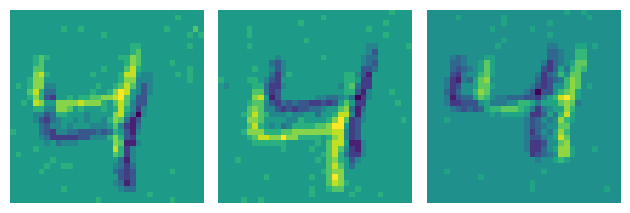

In [ ]:
tonic.utils.plot_event_grid(events)

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as torchvision_transforms
import tonic
import tonic.transforms as transforms

# Define sensor size for NMNIST dataset
sensor_size = tonic.datasets.NMNIST.sensor_size

# Define transformations
# Note: The use of torch.from_numpy is removed as Tonic's transforms handle conversion.
transform = tonic.transforms.Compose([
    transforms.Denoise(filter_time=10000),
    transforms.ToFrame(sensor_size=sensor_size, time_window=10000),
    # torchvision.transforms.RandomRotation is not directly applicable to event data.
    # If rotation is needed, it should be done on the frames after conversion by ToFrame.
])

# Load NMNIST datasets without caching
trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=False)

# Split trainset into training and validation datasets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Fetch a single batch from the train_loader to inspect the shape
data, targets = next(iter(train_loader))
print(f"Data shape: {data.shape}")  # Example output: torch.Size([batch_size, timesteps, channels, height, width])
print(f"Targets shape: {targets.shape}")  # Example output: torch.Size([batch_size])


Data shape: torch.Size([31, 128, 2, 34, 34])
Targets shape: torch.Size([128])


In [ ]:
# Fetch a single batch from the train_loader
data, targets = next(iter(train_loader))

# Assuming your data is in the format [timesteps, batch_size, channels, height, width]
# Check the shape of the data tensor
print(f"Data shape: {data.shape}")

# Check the shape of the targets tensor
print(f"Targets shape: {targets.shape}")

Data shape: torch.Size([31, 128, 2, 34, 34])
Targets shape: torch.Size([128])


### 3. Model Definition

#### 3.1 Parameters

In [6]:
config = {
    # SNN
    "threshold1": 2.5,
    "threshold2": 8.0,
    "threshold3": 4.0,
    "threshold4": 2.0,
    "beta": 0.5,
    "num_steps": 10,
    
    # SNN Dense Shape
    "dense1_input": 2312,
    "num_classes": 10,
    

    # Network
    "batch_norm": True,
    "dropout": 0.3,

    # Hyper Params
    "lr": 0.007,

    # Early Stopping
    "min_delta": 1e-6,
    "patience_es": 20,

    # Training
    "epochs": 2
}

#### 3.2 Model

In [8]:
class SNN(nn.Module):
  def __init__(self, config):
    super(SNN, self).__init__()

    # Initialize configuration parameters
      # LIF
    self.thresh1 = config["threshold1"]
    self.thresh2 = config["threshold2"]
    self.thresh3 = config["threshold3"]
    self.thresh4 = config["threshold4"]
    self.beta = config["beta"]
    self.num_steps = config["num_steps"]

      # Hyper Params for Layers
    self.batch_norm = config["batch_norm"]
    self.dropout_percent = config["dropout"]

      # Dense Shape
    self.dense1_input = config["dense1_input"]
    self.num_classes = config["num_classes"]

      # Network Layers
    self.fc1 = nn.Linear(self.dense1_input, self.dense1_input//4)
    self.lif1 = snn.Leaky(beta=self.beta, threshold=self.thresh1)
    
    
    self.fc2 = nn.Linear(self.dense1_input//4, self.dense1_input//8)
    self.lif2 = snn.Leaky(beta=self.beta, threshold=self.thresh2)
    
    self.fc3 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif3 = snn.Leaky(beta=self.beta, threshold=self.thresh3)
    
    self.flatten = nn.Flatten()
    self.fc4 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif4 = snn.Leaky(beta=self.beta, threshold=self.thresh4)
    self.dropout = nn.Dropout(self.dropout_percent)
    
    # Extra (not used)
    self.batch_norm_1 = nn.BatchNorm2d(num_features=16)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
    
    
    # Forward Pass
  def forward(self, inpt):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()
    #mem4 = self.lif4.init_leaky()

    spike3_rec = []
    mem3_rec = []
    
    #print(inpt.shape)

    for step in range(inpt.shape[0]):
      #print(inpt[step].shape)
      
      current_input = inpt[step]
      current_input = self.flatten(current_input)
      
      current1 = self.fc1(current_input)
      spike1, mem1 = self.lif1(current1, mem1)

      current2 = self.fc2(spike1)
      spike2, mem2 = self.lif2(current2, mem2)

      current3 = self.fc3(spike2)
      spike3, mem3 = self.lif3(current3, mem3)
      
      #current4 = self.fc4(spike3)
      #spike4, mem4 = self.lif4(current4, mem4)

      spike3_rec.append(spike3)
      mem3_rec.append(mem3)

    return torch.stack(spike3_rec, dim=0), torch.stack(mem3_rec, dim=0)

NameError: name 'nn' is not defined

### 4. Training


#### 4.1 Early Stopping

In [10]:
class EarlyStopping:
    def __init__(self, patience=config["patience_es"], min_delta=config["min_delta"]):
        # Early stops the training if validation loss doesn't improve after a given patience.
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            print(f"Earlystop {self.counter}/{self.patience}\n")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

#### 4.2 Training Set-Up

In [11]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN(config).to(device)

# Optimizer and Loss Function
optimizer = Adam(model.parameters(), lr=config["lr"])
criterion = nn.CrossEntropyLoss()

# Early Stopping
early_stopping = EarlyStopping(patience=config["patience_es"], min_delta=config["min_delta"])

NameError: name 'torch' is not defined

#### 4.3 Training Function

In [13]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        #print(data.shape)

        optimizer.zero_grad()
        spike_out, _ = model(data)
        output = spike_out.sum(dim=0)
        loss = criterion(output, targets)
        running_loss += loss.item()

        _, predicted_train = torch.max(output.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()
        
        print(f"Train Loss: {loss.item():.2f}")
        
        acc = SF.accuracy_rate(spike_out, targets) 
        print(f"Accuracy: {acc * 100:.2f}%\n")

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    return train_loss, train_accuracy

#### 4.4 Validation Function

In [17]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            spike_out, _ = model(data)
            output = spike_out.sum(dim=0)
            loss = criterion(output, targets)
            val_loss += loss.item()

            _, predicted_val = torch.max(output.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted_val == targets).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return val_loss, val_accuracy

#### 4.5 Training Loop

In [20]:
from tqdm import tqdm

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
model_path = "best_SNN_model.pth"

for epoch in tqdm(range(config["epochs"]), desc="Epochs"):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    tqdm.write(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.5f}, Training Accuracy: {train_accuracy:.2f}%, "
               f"Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)
        tqdm.write(f"Saved model with improved validation accuracy: {val_accuracy:.2f}% \n")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        tqdm.write("\nEarly stopping triggered")
        break

ModuleNotFoundError: No module named 'tqdm'

### 5. Visualization

In [21]:
# Plotting training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training, validation, and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### 6. Testing

In [23]:
def test(model, test_loader, criterion, device, model_path="best_SNN_model.pth"):

    # Initialize variables for test loss and accuracy
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Restore best SNN Model
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded saved model from {model_path}\n")

    # Switch model to evaluation mode
    model.eval()

    # Iterate over the test data
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(data)  # Modify according to your model's output
            outputs = outputs.mean(dim=0)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    return test_loss, test_accuracy


In [24]:
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

NameError: name 'model' is not defined

### 7. Save weights and biases

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN(config).to(device)

# Load the trained model weights
model_path = "best_SNN_model.pth"
model.load_state_dict(torch.load(model_path))

# Ensure the model is in evaluation mode if it uses layers like dropout or batch normalization
model.eval()

NameError: name 'torch' is not defined

In [ ]:
import pandas as pd

# Load the trained model weights
model_path = "best_SNN_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

for name, param in model.named_parameters():
    param_data = param.detach().cpu().numpy()  # Keep the original shape
    if "weight" in name:
        # Save weights with details
        for output_neuron_index, weights_to_neuron in enumerate(param_data):
            df = pd.DataFrame(weights_to_neuron.reshape(1, -1))  # One output neuron's weights per row
            formatted_name = f"{name}_to_output_neuron_{output_neuron_index}.csv"
            formatted_name = formatted_name.replace(".", "_")  # Format the filename
            df.to_csv(formatted_name, index=False, header=False)
    elif "bias" in name:
        # Save biases directly, as they are already 1D
        df = pd.DataFrame(param_data.reshape(1, -1))  # All biases in one row
        formatted_name = name.replace(".", "_") + ".csv"
        df.to_csv(formatted_name, index=False, header=False)


In [ ]:
import pandas as pd

# Load the trained model weights
model_path = "best_SNN_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

for name, param in model.named_parameters():
    param_data = param.detach().cpu().numpy()  # Keep the original shape
    
    if "weight" in name:
        # Save all weights for the layer in one CSV
        df_weights = pd.DataFrame(param_data)  # Rows: output neurons, Columns: input neurons
        formatted_name_weights = name.replace(".", "_") + "_weights.csv"
        df_weights.to_csv(formatted_name_weights, index=False, header=False)
        
    elif "bias" in name:
        # Save biases for the layer in one CSV
        df_bias = pd.DataFrame(param_data).T  # Convert to row vector for consistency
        formatted_name_bias = name.replace(".", "_") + "_bias.csv"
        df_bias.to_csv(formatted_name_bias, index=False, header=False)


In [ ]:
import torch
import json

# Load the trained model weights
model_path = "best_SNN_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

model_parameters = {}

for name, param in model.named_parameters():
    # Convert parameter to numpy array and then to list for JSON serialization
    param_data = param.detach().cpu().numpy().tolist()  # Use tolist() to make JSON serializable
    
    # Assign parameter data to the corresponding layer name in the dictionary
    model_parameters[name] = param_data

# Define file path for JSON file
json_file_path = "model_parameters.json"

# Save the dictionary to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(model_parameters, json_file, indent=4)


In [ ]:
# Save the weights to CSV files
for name, param in model.named_parameters():
    # Convert the tensor to a numpy array and flatten it
    param_data = param.detach().cpu().numpy().flatten()
    # Create a DataFrame and save it as CSV
    df = pd.DataFrame(param_data)
    # Format the filename to avoid issues with directory separators
    formatted_name = name.replace(".", "_")
    df.to_csv(f"{formatted_name}.csv", index=False, header=False)

In [ ]:
import pandas as pd

# Placeholder for all parameter data
all_params = []

# Collect parameter data
for name, param in model.named_parameters():
    param_data = param.detach().cpu().numpy().flatten()
    for value in param_data:
        all_params.append([name, value])

# Convert to DataFrame
df_params = pd.DataFrame(all_params, columns=['Parameter', 'Value'])

# Save to CSV
df_params.to_csv("model_weights.csv", index=False)


In [ ]:
import json
import torch

model_weights = {}

for name, param in model.named_parameters():
    # Convert the tensor to a list
    param_data = param.detach().cpu().numpy().flatten().tolist()
    model_weights[name] = param_data

# Save to JSON
with open('model_weights.json', 'w') as f:
    json.dump(model_weights, f)


### 8. Save intermediate results from each layer

In [ ]:
class SNN_tests(nn.Module):
  def __init__(self, config):
    super(SNN_tests, self).__init__()

    # Initialize configuration parameters
      # LIF
    self.thresh1 = config["threshold1"]
    self.thresh2 = config["threshold2"]
    self.thresh3 = config["threshold3"]
    self.thresh4 = config["threshold4"]
    self.beta = config["beta"]
    self.num_steps = config["num_steps"]

      # Hyper Params for Layers
    self.batch_norm = config["batch_norm"]
    self.dropout_percent = config["dropout"]

      # Dense Shape
    self.dense1_input = config["dense1_input"]
    self.num_classes = config["num_classes"]

      # Network Layers
    self.fc1 = nn.Linear(self.dense1_input, self.dense1_input//4)
    self.lif1 = snn.Leaky(beta=self.beta, threshold=self.thresh1)
    
    
    self.fc2 = nn.Linear(self.dense1_input//4, self.dense1_input//8)
    self.lif2 = snn.Leaky(beta=self.beta, threshold=self.thresh2)
    
    self.fc3 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif3 = snn.Leaky(beta=self.beta, threshold=self.thresh3)
    
    self.flatten = nn.Flatten()
    self.fc4 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif4 = snn.Leaky(beta=self.beta, threshold=self.thresh4)
    self.dropout = nn.Dropout(self.dropout_percent)
    
    # Extra (not used)
    self.batch_norm_1 = nn.BatchNorm2d(num_features=16)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
    
    
    # Forward Pass
  def forward(self, inpt):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()
    #mem4 = self.lif4.init_leaky()

    spike3_rec = []
    mem3_rec = []
    
    all_outputs = {
            'inputs': [],
            'fc1_outputs': [],
            'lif1_spikes': [],
            'fc2_outputs': [],
            'lif2_spikes': [],
            'fc3_outputs': [],
            'lif3_spikes': [],
            'mem1': [],
            'mem2': [],
            'mem3': []
        }
    
    print(inpt.shape)

    for step in range(inpt.shape[0]):
        current_input = inpt[step]
        #current_input = self.flatten(current_input)
        current_input = torch.Tensor(current_input).to(device)
        current_input = current_input.unsqueeze(0)
        current_input = self.flatten(current_input)
        
        all_outputs['inputs'].append(current_input.cpu().numpy())  # Saving input

        current1 = self.fc1(current_input)
        spike1, mem1 = self.lif1(current1, mem1)
        all_outputs['fc1_outputs'].append(current1.detach().cpu().numpy())  # FC1 output
        all_outputs['lif1_spikes'].append(spike1.detach().cpu().numpy())  # LIF1 spikes
        all_outputs['mem1'].append(mem1.detach().cpu().numpy())

        current2 = self.fc2(spike1)
        spike2, mem2 = self.lif2(current2, mem2)
        all_outputs['fc2_outputs'].append(current2.detach().cpu().numpy())  # FC2 output
        all_outputs['lif2_spikes'].append(spike2.detach().cpu().numpy())  # LIF2 spikes
        all_outputs['mem2'].append(mem2.detach().cpu().numpy())

        current3 = self.fc3(spike2)
        spike3, mem3 = self.lif3(current3, mem3)
        all_outputs['fc3_outputs'].append(current3.detach().cpu().numpy())  # FC3 output
        all_outputs['lif3_spikes'].append(spike3.detach().cpu().numpy())  # LIF3 spikes
        all_outputs['mem3'].append(mem3.detach().cpu().numpy())

        # Continue for other layers as necessary

    return all_outputs

In [ ]:
import pandas as pd

# Model initialization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN_tests(config).to(device)

def save_single_sample_and_label_to_csv(test_loader, sample_file_name="sample.csv", label_file_name="label.csv",
                                        model_path="best_SNN_model.pth"):
    
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded saved model from {model_path}\n")
    
    # Extract the first sample and its label from the DataLoader
    for data, targets in test_loader:
        # Extract the first sample and label
        print(data.shape)
        first_sample = data[:, 0, :, :, :].numpy()  # Adjust this based on your actual data shape
        print(first_sample.shape)
        first_label = targets[0].numpy()

        # Flatten the sample for saving to CSV
        flattened_sample = first_sample.flatten()
        
        # Save the first sample to a CSV file
        df_sample = pd.DataFrame(flattened_sample.reshape(1, -1))
        df_sample.to_csv(sample_file_name, index=False, header=False)
        
        # Save the first label to a CSV file
        df_label = pd.DataFrame([first_label])
        df_label.to_csv(label_file_name, index=False, header=False)
        
        break  # Stop after the first sample
    
    return first_sample

# Assuming test_loader is defined
first_sample = save_single_sample_and_label_to_csv(test_loader)


Loaded saved model from best_SNN_model.pth

torch.Size([31, 128, 2, 34, 34])
(31, 2, 34, 34)


In [ ]:
def save_single_sample_and_label_to_csv(test_loader, model_path="best_SNN_model.pth"):
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded saved model from {model_path}\n")
    
    # Extract the first batch from the DataLoader
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        print(data.shape)
        # Assuming the shape of 'data' is [batch_size, time_steps, channels, height, width]
        # Adjust according to your dataset if needed
        for timestep in range(data.shape[0]):
            # Extract the first sample at the current timestep
            first_sample = data[timestep, 0, :, :, :].cpu().numpy()  # [channels, height, width]
            print(first_sample.shape)
            
            # Flatten the sample for saving to CSV and include the timestep index in the file name
            flattened_sample = first_sample.flatten()
            sample_file_name = f"sample_timestep_{timestep}.csv"
            df_sample = pd.DataFrame(flattened_sample.reshape(1, -1))
            df_sample.to_csv(sample_file_name, index=False, header=False)

        # Assuming the label is a single value, save the label of the first sample
        first_label = targets[0].cpu().numpy()
        label_file_name = "label.csv"
        df_label = pd.DataFrame([first_label])
        df_label.to_csv(label_file_name, index=False, header=False)
        
        break  # Stop after processing the first batch/sample

# Assuming test_loader is defined
save_single_sample_and_label_to_csv(test_loader)

Loaded saved model from best_SNN_model.pth

torch.Size([31, 128, 2, 34, 34])
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)
(2, 34, 34)


In [ ]:
def save_layer_outputs(model, single_sample, device):
    single_sample = single_sample.to(device).unsqueeze(0)  # Add batch dimension
    layer_outputs = model(first_sample)

    # Save each layer's output to a separate CSV file
    for layer_name, output in layer_outputs.items():
        for step, step_output in enumerate(layer_outputs):
            # Convert to DataFrame and save
            #print(step_output.shape)
            df = pd.DataFrame(step_output)
            df.to_csv(f"{layer_name}_timestep_{step}.csv", index=False)

# Example usage:
model.eval()  # Set model to evaluation mode
single_sample, single_label = next(iter(test_loader))  # Assuming test_loader is defined
save_layer_outputs(model, single_sample, device)

(31, 2, 34, 34)


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
def save_layer_outputs(model, single_sample, device):
    # Ensure single_sample is properly shaped
    single_sample = single_sample.unsqueeze(0) if len(single_sample.shape) < 5 else single_sample
    single_sample = single_sample.to(device)
    
    # Get the model's outputs
    layer_outputs = model(first_sample)  # Assuming this returns a dict of layer outputs
    
    # Iterate through each layer's outputs
    for layer_name, outputs in layer_outputs.items():
        # Check if outputs is a list of timesteps; if not, wrap it in a list
        if not isinstance(outputs, list):
            outputs = [outputs]
        
        for step, step_output in enumerate(outputs):
            # Assuming step_output is a tensor, convert it to numpy array
            print(type(step_output))
            step_output_np = step_output

            # Reshape the output if necessary to match your expected format
            # Flatten or adjust dimensions as needed for saving
            # For example, if step_output_np is 4D (batch_size, channels, H, W) and you want to flatten it:
            step_output_flat = step_output_np.flatten()

            # Convert to DataFrame and save
            df = pd.DataFrame(step_output_flat.reshape(1, -1))  # Reshape as 2D data
            df.to_csv(f"{layer_name}_timestep_{step}.csv", index=False)

# Assuming the model and device are defined, and model's forward() is implemented to return layer outputs
model.eval()  # Set model to evaluation mode
single_sample, _ = next(iter(test_loader))  # Grab a single sample
save_layer_outputs(model, single_sample, device)


(31, 2, 34, 34)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
